In [1]:
# Pissible need package install if needed

#Used for import function from other ipynb file
#pip install ipynb

#Install pytorch
#pip install pytorch

In [1]:
import os
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import argparse
from torchvision.utils import save_image
from ipynb.fs.full.utils import get_loops, get_dataset, get_network, get_eval_pool, evaluate_synset, get_daparam, match_loss, get_time, TensorDataset, DiffAugment, ParamDiffAug
import matplotlib.pyplot as plt

In [2]:
from ptflops import get_model_complexity_info

In [3]:
mnist_data = "mnist_data"
mnist_result = "mnist_result"

if not os.path.exists(mnist_data):
    os.mkdir(mnist_data)

if not os.path.exists(mnist_result):
    os.mkdir(mnist_result)

cifar_data = "cifar_data"
cifar_result = "cifar_result"

if not os.path.exists(cifar_data):
    os.mkdir(cifar_data)

if not os.path.exists(cifar_result):
    os.mkdir(cifar_result)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
#load data
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('MNIST',mnist_data)

In [6]:
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

In [7]:
images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

In [8]:
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

In [9]:
for c in range(num_classes):
    print('class c = %d: %d real images'%(c, len(indices_class[c])))

class c = 0: 5923 real images
class c = 1: 6742 real images
class c = 2: 5958 real images
class c = 3: 6131 real images
class c = 4: 5842 real images
class c = 5: 5421 real images
class c = 6: 5918 real images
class c = 7: 6265 real images
class c = 8: 5851 real images
class c = 9: 5949 real images


# 2 a

In [72]:
#Get the net
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

In [13]:
#first train with dataset
def epoch(mode, dataloader, net, optimizer, criterion,device):
    loss_avg, acc_avg, num_exp = 0,0,0
    net = net.to(device)
    criterion = criterion.to(device)
    if mode == 'train':
        net.train()
    else:
        net.eval()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10)
    for i_batch,datum in enumerate(dataloader):
        img = datum[0].float().to(device)
        lab = datum[1].long().to(device)
        n_b = lab.shape[0]
        
        output = net(img)
        loss = criterion(output,lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))
        
        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b
        
        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
    loss_avg /= num_exp
    acc_avg /= num_exp
    
    return loss_avg, acc_avg


def train_with_dataset(net, images_train, labels_train, testloader,device):
    net = net.to(device)
    images_train = images_train.to(device)
    labels_train = labels_train.to(device)
    lr = 0.01
    Epoch = 20
    optimizer = torch.optim.SGD(net.parameters(), lr = lr, momentum = 0.9, weight_decay = 0.0005)
    criterion = nn.CrossEntropyLoss().to(device)
    dst_train = TensorDataset(images_train,labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size = 256, shuffle = True, num_workers = 0)
    for ep in range(Epoch):
        loss_train, acc_train = epoch('train',trainloader, net, optimizer, criterion, device)
        print("loss train: {}, acc_train: {}".format(loss_train, acc_train))
    loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion, device)
    return acc_train, acc_test


In [10]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)
images, labels = copy.deepcopy(images_all.detach()), copy.deepcopy(labels_all.detach())

In [11]:
macs, params = get_model_complexity_info(ConvNet, (1,28,28), as_strings = True,
                                        print_per_layer_stat = True, verbose = True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))

ConvNet(
  317.71 k, 100.000% Params, 49.25 MMac, 100.000% MACs, 
  (features): Sequential(
    297.22 k, 93.551% Params, 49.23 MMac, 99.958% MACs, 
    (0): Conv2d(1.28 k, 0.403% Params, 1.31 MMac, 2.662% MACs, 1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(256, 0.081% Params, 262.14 KMac, 0.532% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 131.07 KMac, 0.266% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 131.07 KMac, 0.266% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 46.453% Params, 37.78 MMac, 76.720% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.081% Params, 65.54 KMac, 0.133% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 32.77 KMac, 0.067% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 32.77 KMac, 0.067% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 46.453% Params, 9.45 MMac, 19.180% MA

In [12]:
acc_train,acc_test = train_with_dataset(ConvNet,images, labels, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 0.2841838123043378, acc_train: 0.93195
loss train: 0.06805729623834292, acc_train: 0.9822833333333333
loss train: 0.051565202138821285, acc_train: 0.9862166666666666
loss train: 0.04376972884039084, acc_train: 0.9880166666666667
loss train: 0.03688659320274989, acc_train: 0.98985
loss train: 0.03631744081179301, acc_train: 0.9896333333333334
loss train: 0.03203204917311668, acc_train: 0.9914166666666666
loss train: 0.028420025177299975, acc_train: 0.9921
loss train: 0.027141653450330098, acc_train: 0.99255
loss train: 0.02546396706899007, acc_train: 0.99325
loss train: 0.022170541329185167, acc_train: 0.9939666666666667
loss train: 0.020936106424530348, acc_train: 0.9945333333333334
loss train: 0.019473087057471274, acc_train: 0.9949
loss train: 0.019056514712174732, acc_train: 0.9951166666666666
loss train: 0.017664020450909933, acc_train: 0.99535
loss train: 0.01686749543795983, acc_train: 0.9957833333333334
loss train: 0.01577594166348378, acc_train: 0.9960833333333333
l

# 2 b

In [12]:
K = 100
T = 10
learningRateCondensedSamples = 0.1
numberOptimizationSteps = 1
learningRateModel = 0.01
numberOfOptimizationSteps = 50
ipc = 10
miniBatchSize = 256

In [76]:
#initialize the synthetic data
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


C:\Users\alanw\AppData\Local\Temp\ipykernel_12252\3204847356.py:3: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


In [10]:
def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

In [78]:
for c in range(num_classes):
    image_syn.data[c*ipc:(c+1)*ipc] = get_images(c, ipc).detach().data

In [79]:
#Train
optimizer_img = torch.optim.SGD([image_syn], lr = learningRateCondensedSamples, momentum = 0.5)
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device)

In [80]:
net = get_network('ConvNet',channel,num_classes,im_size).to(device)
net.train()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(), lr = learningRateModel)
optimizer_net.zero_grad()
loss_avg = 0

In [81]:
parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
args, unknown = parser.parse_known_args()
args.device = device

In [82]:
for ol in range(K):
    loss = torch.tensor(0.0).to(device)
    print("Outer Loop {}".format(ol))
    for c in range(num_classes):
        img_real = get_images(c, miniBatchSize)
        lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
        img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel, im_size[0], im_size[1]))
        lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
        
        output_real = net(img_real)
        loss_real = criterion(output_real, lab_real)
        gw_real = torch.autograd.grad(loss_real, net_parameters)
        gw_real = list((_.detach().clone() for _ in gw_real))
        
        output_syn = net(img_syn)
        loss_syn = criterion(output_syn, lab_syn)
        gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)
        loss += match_loss(gw_syn, gw_real, args)
    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()
    
    if ol == K - 1:
        break
    
    ''' update network '''
    image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
    dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
    trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=miniBatchSize, shuffle=True, num_workers=0)
    for il in range(T):
        epoch('train', trainloader, net, optimizer_net, criterion, device)

loss_avg /= (num_classes*K)
print('loss = %.4f' % loss_avg)
    

Outer Loop 0
Outer Loop 1
Outer Loop 2
Outer Loop 3
Outer Loop 4
Outer Loop 5
Outer Loop 6
Outer Loop 7
Outer Loop 8
Outer Loop 9
Outer Loop 10
Outer Loop 11
Outer Loop 12
Outer Loop 13
Outer Loop 14
Outer Loop 15
Outer Loop 16
Outer Loop 17
Outer Loop 18
Outer Loop 19
Outer Loop 20
Outer Loop 21
Outer Loop 22
Outer Loop 23
Outer Loop 24
Outer Loop 25
Outer Loop 26
Outer Loop 27
Outer Loop 28
Outer Loop 29
Outer Loop 30
Outer Loop 31
Outer Loop 32
Outer Loop 33
Outer Loop 34
Outer Loop 35
Outer Loop 36
Outer Loop 37
Outer Loop 38
Outer Loop 39
Outer Loop 40
Outer Loop 41
Outer Loop 42
Outer Loop 43
Outer Loop 44
Outer Loop 45
Outer Loop 46
Outer Loop 47
Outer Loop 48
Outer Loop 49
Outer Loop 50
Outer Loop 51
Outer Loop 52
Outer Loop 53
Outer Loop 54
Outer Loop 55
Outer Loop 56
Outer Loop 57
Outer Loop 58
Outer Loop 59
Outer Loop 60
Outer Loop 61
Outer Loop 62
Outer Loop 63
Outer Loop 64
Outer Loop 65
Outer Loop 66
Outer Loop 67
Outer Loop 68
Outer Loop 69
Outer Loop 70
Outer Loop 71
Ou

In [83]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

#----------------------------------------MNIST result --------------------------------------------------------------------
mnist_images_sync, mnist_labels_sync = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
#----------------------------------------------------------------------------------------------------------------------------

acc_train,acc_test = train_with_dataset(ConvNet,mnist_images_sync, mnist_labels_sync, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.332111358642578, acc_train: 0.13
loss train: 2.206742525100708, acc_train: 0.26
loss train: 2.050590991973877, acc_train: 0.53
loss train: 1.874452829360962, acc_train: 0.67
loss train: 1.6859163045883179, acc_train: 0.83
loss train: 1.5162575244903564, acc_train: 0.88
loss train: 1.36368989944458, acc_train: 0.88
loss train: 1.2110499143600464, acc_train: 0.91
loss train: 1.0659754276275635, acc_train: 0.96
loss train: 0.9374483227729797, acc_train: 0.96
loss train: 0.821342945098877, acc_train: 0.98
loss train: 0.7170741558074951, acc_train: 0.98
loss train: 0.6267210245132446, acc_train: 0.98
loss train: 0.548811137676239, acc_train: 0.98
loss train: 0.4815305471420288, acc_train: 0.98
loss train: 0.42389756441116333, acc_train: 0.98
loss train: 0.3747239410877228, acc_train: 0.98
loss train: 0.33216655254364014, acc_train: 0.98
loss train: 0.29498934745788574, acc_train: 0.98
loss train: 0.26266881823539734, acc_train: 0.98
Acc train 0.98, Acc test 0.9005


# 1 c

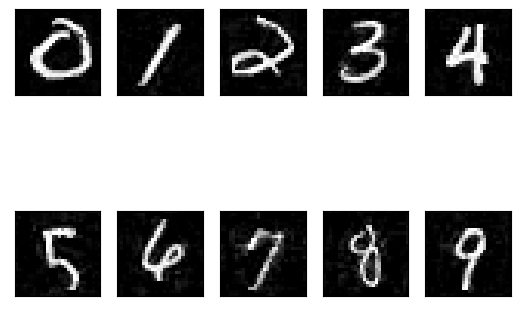

In [23]:
image_syn_vis = copy.deepcopy(image_syn.detach().cpu())
for ch in range(channel):
    image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
image_syn_vis[image_syn_vis<0] = 0.0
image_syn_vis[image_syn_vis>1] = 1.0
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(image_syn_vis[0+i*10][0], cmap=plt.cm.gray)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [20]:
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('CIFAR10',mnist_data)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

In [22]:
images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

In [23]:
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

In [24]:
#base line
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)
images, labels = copy.deepcopy(images_all.detach()), copy.deepcopy(labels_all.detach())

In [25]:
acc_train,acc_test = train_with_dataset(ConvNet,images, labels, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 1.547944690475464, acc_train: 0.45918
loss train: 1.1248282262802125, acc_train: 0.61028
loss train: 0.9779403326416015, acc_train: 0.66222
loss train: 0.8702254090499878, acc_train: 0.70054
loss train: 0.8022110078239441, acc_train: 0.7265
loss train: 0.7415004912185669, acc_train: 0.74686
loss train: 0.7025171150588989, acc_train: 0.76236
loss train: 0.6469329987716674, acc_train: 0.78284
loss train: 0.6112999915695191, acc_train: 0.79486
loss train: 0.58758383228302, acc_train: 0.80236
loss train: 0.5449114079666137, acc_train: 0.8203
loss train: 0.5173571387290955, acc_train: 0.82806
loss train: 0.4919164423942566, acc_train: 0.83784
loss train: 0.4825076996707916, acc_train: 0.8398
loss train: 0.4504186312007904, acc_train: 0.85238
loss train: 0.448761411819458, acc_train: 0.85076
loss train: 0.40977212065696716, acc_train: 0.86676
loss train: 0.38171847384452817, acc_train: 0.87616
loss train: 0.371153772726059, acc_train: 0.87878
loss train: 0.35723356925964356, acc_

In [26]:
#initialize syn image
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]
for c in range(num_classes):
    image_syn.data[c*ipc:(c+1)*ipc] = get_images(c, ipc).detach().data

C:\Users\alanw\AppData\Local\Temp\ipykernel_12252\3004736898.py:3: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


In [27]:
optimizer_img = torch.optim.SGD([image_syn], lr = learningRateCondensedSamples, momentum = 0.5)
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device)

In [28]:
net = get_network('ConvNet',channel,num_classes,im_size).to(device)
net.train()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(), lr = learningRateModel)
optimizer_net.zero_grad()
loss_avg = 0

In [29]:
parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
args, unknown = parser.parse_known_args()
args.device = device

In [30]:
for ol in range(K):
    loss = torch.tensor(0.0).to(device)
    print("Outer Loop {}".format(ol))
    for c in range(num_classes):
        img_real = get_images(c, miniBatchSize)
        lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
        img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel, im_size[0], im_size[1]))
        lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
        
        output_real = net(img_real)
        loss_real = criterion(output_real, lab_real)
        gw_real = torch.autograd.grad(loss_real, net_parameters)
        gw_real = list((_.detach().clone() for _ in gw_real))
        
        output_syn = net(img_syn)
        loss_syn = criterion(output_syn, lab_syn)
        gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)
        loss += match_loss(gw_syn, gw_real, args)
    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()
    
    if ol == K - 1:
        break
    
    ''' update network '''
    image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
    dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
    trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=miniBatchSize, shuffle=True, num_workers=0)
    for il in range(T):
        epoch('train', trainloader, net, optimizer_net, criterion, device)

loss_avg /= (num_classes*K)

Outer Loop 0
Outer Loop 1
Outer Loop 2
Outer Loop 3
Outer Loop 4
Outer Loop 5
Outer Loop 6
Outer Loop 7
Outer Loop 8
Outer Loop 9
Outer Loop 10
Outer Loop 11
Outer Loop 12
Outer Loop 13
Outer Loop 14
Outer Loop 15
Outer Loop 16
Outer Loop 17
Outer Loop 18
Outer Loop 19
Outer Loop 20
Outer Loop 21
Outer Loop 22
Outer Loop 23
Outer Loop 24
Outer Loop 25
Outer Loop 26
Outer Loop 27
Outer Loop 28
Outer Loop 29
Outer Loop 30
Outer Loop 31
Outer Loop 32
Outer Loop 33
Outer Loop 34
Outer Loop 35
Outer Loop 36
Outer Loop 37
Outer Loop 38
Outer Loop 39
Outer Loop 40
Outer Loop 41
Outer Loop 42
Outer Loop 43
Outer Loop 44
Outer Loop 45
Outer Loop 46
Outer Loop 47
Outer Loop 48
Outer Loop 49
Outer Loop 50
Outer Loop 51
Outer Loop 52
Outer Loop 53
Outer Loop 54
Outer Loop 55
Outer Loop 56
Outer Loop 57
Outer Loop 58
Outer Loop 59
Outer Loop 60
Outer Loop 61
Outer Loop 62
Outer Loop 63
Outer Loop 64
Outer Loop 65
Outer Loop 66
Outer Loop 67
Outer Loop 68
Outer Loop 69
Outer Loop 70
Outer Loop 71
Ou

In [31]:
print('loss = %.4f' % loss_avg)

loss = 96.8068


In [32]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

#----------------------------------------CIFAR result --------------------------------------------------------------------
cifar_images_sync, cifar_labels_sync = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
#----------------------------------------------------------------------------------------------------------------------------

acc_train,acc_test = train_with_dataset(ConvNet,cifar_images_sync, cifar_labels_sync, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.3496086597442627, acc_train: 0.14
loss train: 2.241914987564087, acc_train: 0.22
loss train: 2.096734046936035, acc_train: 0.39
loss train: 1.9544011354446411, acc_train: 0.49
loss train: 1.817063808441162, acc_train: 0.55
loss train: 1.6802949905395508, acc_train: 0.65
loss train: 1.5463279485702515, acc_train: 0.73
loss train: 1.423551321029663, acc_train: 0.75
loss train: 1.3114935159683228, acc_train: 0.76
loss train: 1.2043594121932983, acc_train: 0.81
loss train: 1.1015599966049194, acc_train: 0.87
loss train: 1.0055829286575317, acc_train: 0.91
loss train: 0.9173674583435059, acc_train: 0.93
loss train: 0.836608350276947, acc_train: 0.94
loss train: 0.7630935907363892, acc_train: 0.94
loss train: 0.6949479579925537, acc_train: 0.95
loss train: 0.6313177347183228, acc_train: 0.95
loss train: 0.57337486743927, acc_train: 0.98
loss train: 0.5214222073554993, acc_train: 0.98
loss train: 0.4742589592933655, acc_train: 0.98
Acc train 0.98, Acc test 0.3259


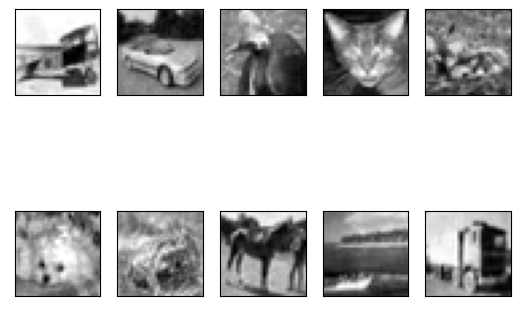

In [37]:
image_syn_vis = copy.deepcopy(image_syn.detach().cpu())
for ch in range(channel):
    image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
image_syn_vis[image_syn_vis<0] = 0.0
image_syn_vis[image_syn_vis>1] = 1.0
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(image_syn_vis[0+i*10][0], cmap=plt.cm.gray)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# 2 d

In [5]:
# ------------------------MNIST initialize with noisy-----------------------------------------
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('MNIST',mnist_data)
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

In [8]:
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

C:\Users\alanw\AppData\Local\Temp\ipykernel_10412\2139612781.py:2: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]
C:\Users\alanw\AppData\Local\Temp\ipykernel_10412\2139612781.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


In [14]:
optimizer_img = torch.optim.SGD([image_syn], lr = learningRateCondensedSamples, momentum = 0.5)
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device)
net = get_network('ConvNet',channel,num_classes,im_size).to(device)
net.train()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(), lr = learningRateModel)
optimizer_net.zero_grad()
loss_avg = 0

parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
args, unknown = parser.parse_known_args()
args.device = device

for ol in range(K):
    loss = torch.tensor(0.0).to(device)
    print("Outer Loop {}".format(ol))
    for c in range(num_classes):
        img_real = get_images(c, miniBatchSize)
        lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
        img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel, im_size[0], im_size[1]))
        lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
        
        output_real = net(img_real)
        loss_real = criterion(output_real, lab_real)
        gw_real = torch.autograd.grad(loss_real, net_parameters)
        gw_real = list((_.detach().clone() for _ in gw_real))
        
        output_syn = net(img_syn)
        loss_syn = criterion(output_syn, lab_syn)
        gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)
        loss += match_loss(gw_syn, gw_real, args)
    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()
    
    if ol == K - 1:
        break
    
    ''' update network '''
    image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
    dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
    trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=miniBatchSize, shuffle=True, num_workers=0)
    for il in range(T):
        epoch('train', trainloader, net, optimizer_net, criterion, device)

loss_avg /= (num_classes*K)

Outer Loop 0
Outer Loop 1
Outer Loop 2
Outer Loop 3
Outer Loop 4
Outer Loop 5
Outer Loop 6
Outer Loop 7
Outer Loop 8
Outer Loop 9
Outer Loop 10
Outer Loop 11
Outer Loop 12
Outer Loop 13
Outer Loop 14
Outer Loop 15
Outer Loop 16
Outer Loop 17
Outer Loop 18
Outer Loop 19
Outer Loop 20
Outer Loop 21
Outer Loop 22
Outer Loop 23
Outer Loop 24
Outer Loop 25
Outer Loop 26
Outer Loop 27
Outer Loop 28
Outer Loop 29
Outer Loop 30
Outer Loop 31
Outer Loop 32
Outer Loop 33
Outer Loop 34
Outer Loop 35
Outer Loop 36
Outer Loop 37
Outer Loop 38
Outer Loop 39
Outer Loop 40
Outer Loop 41
Outer Loop 42
Outer Loop 43
Outer Loop 44
Outer Loop 45
Outer Loop 46
Outer Loop 47
Outer Loop 48
Outer Loop 49
Outer Loop 50
Outer Loop 51
Outer Loop 52
Outer Loop 53
Outer Loop 54
Outer Loop 55
Outer Loop 56
Outer Loop 57
Outer Loop 58
Outer Loop 59
Outer Loop 60
Outer Loop 61
Outer Loop 62
Outer Loop 63
Outer Loop 64
Outer Loop 65
Outer Loop 66
Outer Loop 67
Outer Loop 68
Outer Loop 69
Outer Loop 70
Outer Loop 71
Ou

In [41]:
print('loss = %.4f' % loss_avg)

loss = 107.7482


In [42]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

#----------------------------------------MNIST result --------------------------------------------------------------------
mnist_images_sync_noisy, mnist_labels_sync_noisy = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
#----------------------------------------------------------------------------------------------------------------------------

acc_train,acc_test = train_with_dataset(ConvNet,mnist_images_sync_noisy, mnist_labels_sync_noisy, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.3337786197662354, acc_train: 0.08
loss train: 2.254047155380249, acc_train: 0.21
loss train: 2.151765823364258, acc_train: 0.33
loss train: 2.033015727996826, acc_train: 0.39
loss train: 1.8860864639282227, acc_train: 0.73
loss train: 1.7364388704299927, acc_train: 0.94
loss train: 1.6016851663589478, acc_train: 0.93
loss train: 1.4677250385284424, acc_train: 0.96
loss train: 1.329785943031311, acc_train: 0.97
loss train: 1.2014422416687012, acc_train: 0.97
loss train: 1.0858368873596191, acc_train: 0.97
loss train: 0.9749681949615479, acc_train: 0.98
loss train: 0.8700473308563232, acc_train: 0.99
loss train: 0.7767363786697388, acc_train: 0.99
loss train: 0.6944186687469482, acc_train: 0.99
loss train: 0.6201221942901611, acc_train: 0.99
loss train: 0.5531710982322693, acc_train: 0.99
loss train: 0.49389365315437317, acc_train: 1.0
loss train: 0.44188934564590454, acc_train: 1.0
loss train: 0.3963097631931305, acc_train: 1.0
Acc train 1.0, Acc test 0.7819


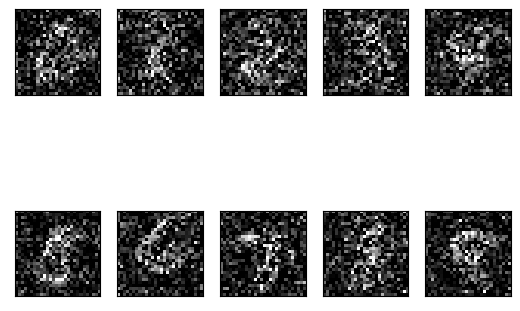

In [15]:
image_syn_vis = copy.deepcopy(image_syn.detach().cpu())
for ch in range(channel):
    image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
image_syn_vis[image_syn_vis<0] = 0.0
image_syn_vis[image_syn_vis>1] = 1.0
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(image_syn_vis[0+i*10][0], cmap=plt.cm.gray)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [16]:
# ------------------------CIFAR initialize with noisy-----------------------------------------
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('CIFAR10',mnist_data)
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

C:\Users\alanw\AppData\Local\Temp\ipykernel_10412\2139612781.py:2: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


In [18]:
optimizer_img = torch.optim.SGD([image_syn], lr = learningRateCondensedSamples, momentum = 0.5)
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device)
net = get_network('ConvNet',channel,num_classes,im_size).to(device)
net.train()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(), lr = learningRateModel)
optimizer_net.zero_grad()
loss_avg = 0

parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
args, unknown = parser.parse_known_args()
args.device = device

for ol in range(K):
    loss = torch.tensor(0.0).to(device)
    print("Outer Loop {}".format(ol))
    for c in range(num_classes):
        img_real = get_images(c, miniBatchSize)
        lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
        img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel, im_size[0], im_size[1]))
        lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
        
        output_real = net(img_real)
        loss_real = criterion(output_real, lab_real)
        gw_real = torch.autograd.grad(loss_real, net_parameters)
        gw_real = list((_.detach().clone() for _ in gw_real))
        
        output_syn = net(img_syn)
        loss_syn = criterion(output_syn, lab_syn)
        gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)
        loss += match_loss(gw_syn, gw_real, args)
    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()
    
    if ol == K - 1:
        break
    
    ''' update network '''
    image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
    dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
    trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=miniBatchSize, shuffle=True, num_workers=0)
    for il in range(T):
        epoch('train', trainloader, net, optimizer_net, criterion, device)

loss_avg /= (num_classes*K)

Outer Loop 0
Outer Loop 1
Outer Loop 2
Outer Loop 3
Outer Loop 4
Outer Loop 5
Outer Loop 6
Outer Loop 7
Outer Loop 8
Outer Loop 9
Outer Loop 10
Outer Loop 11
Outer Loop 12
Outer Loop 13
Outer Loop 14
Outer Loop 15
Outer Loop 16
Outer Loop 17
Outer Loop 18
Outer Loop 19
Outer Loop 20
Outer Loop 21
Outer Loop 22
Outer Loop 23
Outer Loop 24
Outer Loop 25
Outer Loop 26
Outer Loop 27
Outer Loop 28
Outer Loop 29
Outer Loop 30
Outer Loop 31
Outer Loop 32
Outer Loop 33
Outer Loop 34
Outer Loop 35
Outer Loop 36
Outer Loop 37
Outer Loop 38
Outer Loop 39
Outer Loop 40
Outer Loop 41
Outer Loop 42
Outer Loop 43
Outer Loop 44
Outer Loop 45
Outer Loop 46
Outer Loop 47
Outer Loop 48
Outer Loop 49
Outer Loop 50
Outer Loop 51
Outer Loop 52
Outer Loop 53
Outer Loop 54
Outer Loop 55
Outer Loop 56
Outer Loop 57
Outer Loop 58
Outer Loop 59
Outer Loop 60
Outer Loop 61
Outer Loop 62
Outer Loop 63
Outer Loop 64
Outer Loop 65
Outer Loop 66
Outer Loop 67
Outer Loop 68
Outer Loop 69
Outer Loop 70
Outer Loop 71
Ou

In [46]:
print('loss = %.4f' % loss_avg)

loss = 145.3289


In [47]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

#----------------------------------------CIFAR result --------------------------------------------------------------------
cifar_images_sync_noisy, cifar_labels_sync_noisy = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())
#----------------------------------------------------------------------------------------------------------------------------

acc_train,acc_test = train_with_dataset(ConvNet,cifar_images_sync_noisy, cifar_labels_sync_noisy, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.3202176094055176, acc_train: 0.13
loss train: 2.233461380004883, acc_train: 0.23
loss train: 2.101426601409912, acc_train: 0.49
loss train: 1.9425573348999023, acc_train: 0.67
loss train: 1.7598282098770142, acc_train: 0.81
loss train: 1.5652049779891968, acc_train: 0.93
loss train: 1.380793571472168, acc_train: 0.98
loss train: 1.217920184135437, acc_train: 0.96
loss train: 1.0710244178771973, acc_train: 0.97
loss train: 0.9346667528152466, acc_train: 0.97
loss train: 0.8133222460746765, acc_train: 0.99
loss train: 0.7100290060043335, acc_train: 0.99
loss train: 0.6215379238128662, acc_train: 1.0
loss train: 0.5434257388114929, acc_train: 1.0
loss train: 0.47414809465408325, acc_train: 1.0
loss train: 0.41412457823753357, acc_train: 1.0
loss train: 0.3631823658943176, acc_train: 1.0
loss train: 0.31983134150505066, acc_train: 1.0
loss train: 0.28235071897506714, acc_train: 1.0
loss train: 0.2496950775384903, acc_train: 1.0
Acc train 1.0, Acc test 0.2677


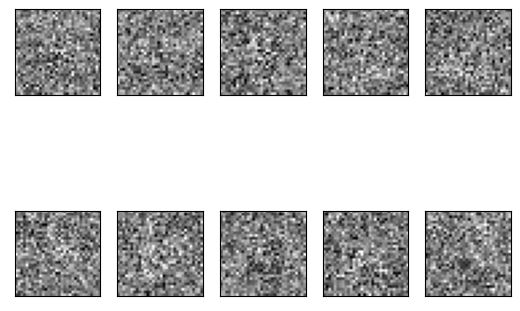

In [19]:
image_syn_vis = copy.deepcopy(image_syn.detach().cpu())
for ch in range(channel):
    image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
image_syn_vis[image_syn_vis<0] = 0.0
image_syn_vis[image_syn_vis>1] = 1.0
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(image_syn_vis[0+i*10][0], cmap=plt.cm.gray)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# 2 e

In [48]:
# ------------------------MNIST------------------------------------
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('MNIST',mnist_data)

ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

acc_train,acc_test = train_with_dataset(ConvNet,mnist_images_sync, mnist_labels_sync, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.3363795280456543, acc_train: 0.07
loss train: 2.2268223762512207, acc_train: 0.26
loss train: 2.081747055053711, acc_train: 0.39
loss train: 1.9178106784820557, acc_train: 0.5
loss train: 1.7470426559448242, acc_train: 0.84
loss train: 1.5921438932418823, acc_train: 0.86
loss train: 1.4433599710464478, acc_train: 0.86
loss train: 1.2935413122177124, acc_train: 0.88
loss train: 1.152909278869629, acc_train: 0.93
loss train: 1.0273029804229736, acc_train: 0.94
loss train: 0.9121400713920593, acc_train: 0.94
loss train: 0.8059871196746826, acc_train: 0.95
loss train: 0.7129393219947815, acc_train: 0.95
loss train: 0.631771981716156, acc_train: 0.95
loss train: 0.559114396572113, acc_train: 0.95
loss train: 0.4947793483734131, acc_train: 0.98
loss train: 0.4396360516548157, acc_train: 0.98
loss train: 0.3921763598918915, acc_train: 0.99
loss train: 0.351004958152771, acc_train: 0.99
loss train: 0.3150831162929535, acc_train: 1.0
Acc train 1.0, Acc test 0.8841


In [49]:
#-----------------------CIFAR Result------------------------------------
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('CIFAR10',mnist_data)

ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)

acc_train,acc_test = train_with_dataset(ConvNet,cifar_images_sync, cifar_labels_sync, testloader, device)

print("Acc train {}, Acc test {}".format(acc_train, acc_test))

Files already downloaded and verified
Files already downloaded and verified
loss train: 2.3329641819000244, acc_train: 0.13
loss train: 2.2237932682037354, acc_train: 0.17
loss train: 2.0720787048339844, acc_train: 0.34
loss train: 1.9291452169418335, acc_train: 0.42
loss train: 1.7976535558700562, acc_train: 0.49
loss train: 1.661523461341858, acc_train: 0.63
loss train: 1.5262269973754883, acc_train: 0.67
loss train: 1.403337836265564, acc_train: 0.72
loss train: 1.2926316261291504, acc_train: 0.76
loss train: 1.1867481470108032, acc_train: 0.81
loss train: 1.0842550992965698, acc_train: 0.84
loss train: 0.9878842234611511, acc_train: 0.87
loss train: 0.8992829322814941, acc_train: 0.91
loss train: 0.8193562030792236, acc_train: 0.93
loss train: 0.7462556958198547, acc_train: 0.94
loss train: 0.6776326894760132, acc_train: 0.95
loss train: 0.613244891166687, acc_train: 0.95
loss train: 0.5547217726707458, acc_train: 0.98
loss train: 0.5026925802230835, acc_train: 0.98
loss train: 0.4

# 3

### Use ResNet-18 to evaluate the cross-architecture performace

## MNIST Dataset

In [52]:
# Base Line of ResNet 18
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('MNIST',mnist_data)
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

In [53]:
ResNet = get_network('ResNet18',channel,num_classes,im_size).to(device)
images, labels = copy.deepcopy(images_all.detach()), copy.deepcopy(labels_all.detach())

In [54]:
acc_train,acc_test = train_with_dataset(ResNet,images, labels, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 0.6522180804948012, acc_train: 0.8387666666666667
loss train: 0.07006093458930651, acc_train: 0.9839166666666667
loss train: 0.04252583730618159, acc_train: 0.9894166666666667
loss train: 0.029201106856266656, acc_train: 0.9929166666666667
loss train: 0.02296888309121132, acc_train: 0.9947166666666667
loss train: 0.016170782225330672, acc_train: 0.9965666666666667
loss train: 0.014044868513320883, acc_train: 0.9967833333333334
loss train: 0.00878705214522779, acc_train: 0.99855
loss train: 0.005860365565617879, acc_train: 0.9992666666666666
loss train: 0.004034458539510766, acc_train: 0.9997333333333334
loss train: 0.003385091878908376, acc_train: 0.9998166666666667
loss train: 0.0027067377265542745, acc_train: 0.9999
loss train: 0.002452658096452554, acc_train: 0.9999
loss train: 0.0018649009206021824, acc_train: 0.9999666666666667
loss train: 0.001587719494352738, acc_train: 0.9999833333333333
loss train: 0.0014551771203676859, acc_train: 0.9999833333333333
loss train: 0.

In [56]:
# MNIST Sync Data set
ResNet = get_network('ResNet18',channel,num_classes,im_size).to(device)

acc_train,acc_test = train_with_dataset(ResNet,mnist_images_sync, mnist_labels_sync, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.3405396938323975, acc_train: 0.1
loss train: 2.229656934738159, acc_train: 0.26
loss train: 2.1502790451049805, acc_train: 0.86
loss train: 2.105726718902588, acc_train: 0.73
loss train: 2.0491209030151367, acc_train: 0.55
loss train: 1.9862556457519531, acc_train: 0.63
loss train: 1.9146201610565186, acc_train: 0.91
loss train: 1.8686784505844116, acc_train: 1.0
loss train: 1.756156325340271, acc_train: 1.0
loss train: 1.6904873847961426, acc_train: 1.0
loss train: 1.6063123941421509, acc_train: 1.0
loss train: 1.5292582511901855, acc_train: 1.0
loss train: 1.4484022855758667, acc_train: 1.0
loss train: 1.353452444076538, acc_train: 1.0
loss train: 1.2954258918762207, acc_train: 1.0
loss train: 1.2131520509719849, acc_train: 1.0
loss train: 1.1311182975769043, acc_train: 1.0
loss train: 1.0523457527160645, acc_train: 1.0
loss train: 0.9837799072265625, acc_train: 1.0
loss train: 0.9231588840484619, acc_train: 1.0
Acc train 1.0, Acc test 0.6295


In [65]:
#CIFAR10 Base Line
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('CIFAR10',mnist_data)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

In [67]:
images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

In [68]:
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

In [69]:
ResNet = get_network('ResNet18',channel,num_classes,im_size).to(device)
images, labels = copy.deepcopy(images_all.detach()), copy.deepcopy(labels_all.detach())

In [70]:
acc_train,acc_test = train_with_dataset(ResNet,images, labels, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.036607031478882, acc_train: 0.26326
loss train: 1.5018463986968995, acc_train: 0.4605
loss train: 1.215119382095337, acc_train: 0.56598
loss train: 1.0122235955619812, acc_train: 0.64308
loss train: 0.8637059362983703, acc_train: 0.69884
loss train: 0.7221135065078735, acc_train: 0.75034
loss train: 0.6189231509017944, acc_train: 0.78894
loss train: 0.502977168006897, acc_train: 0.83086
loss train: 0.4397917521381378, acc_train: 0.85248
loss train: 0.31992912160873416, acc_train: 0.89612
loss train: 0.23575835165977477, acc_train: 0.92734
loss train: 0.19226633197784423, acc_train: 0.94108
loss train: 0.12698204562187196, acc_train: 0.96372
loss train: 0.11050963909626008, acc_train: 0.96906
loss train: 0.04161904918193817, acc_train: 0.9917
loss train: 0.023255673828721048, acc_train: 0.99628
loss train: 0.0080251327586174, acc_train: 0.99954
loss train: 0.0032655021856725216, acc_train: 0.99992
loss train: 0.0024474854984879494, acc_train: 0.99996
loss train: 0.00206965

In [73]:
# CIFAR Sync Data set
ResNet = get_network('ResNet18',channel,num_classes,im_size).to(device)
acc_train,acc_test = train_with_dataset(ResNet, cifar_images_sync, cifar_labels_sync, testloader, device)
print("Acc train {}, Acc test {}".format(acc_train, acc_test))

loss train: 2.350419044494629, acc_train: 0.1
loss train: 2.2174603939056396, acc_train: 0.21
loss train: 2.1183176040649414, acc_train: 0.92
loss train: 2.1150474548339844, acc_train: 0.69
loss train: 2.0140609741210938, acc_train: 0.71
loss train: 1.9636225700378418, acc_train: 0.78
loss train: 1.865300178527832, acc_train: 0.87
loss train: 1.7489840984344482, acc_train: 1.0
loss train: 1.6692309379577637, acc_train: 1.0
loss train: 1.6515741348266602, acc_train: 1.0
loss train: 1.6731828451156616, acc_train: 0.99
loss train: 1.4895453453063965, acc_train: 1.0
loss train: 1.4077165126800537, acc_train: 1.0
loss train: 1.3147785663604736, acc_train: 1.0
loss train: 1.2647818326950073, acc_train: 1.0
loss train: 1.1701388359069824, acc_train: 1.0
loss train: 1.0870307683944702, acc_train: 1.0
loss train: 1.0515820980072021, acc_train: 1.0
loss train: 0.9821707010269165, acc_train: 1.0
loss train: 0.9116523265838623, acc_train: 1.0
Acc train 1.0, Acc test 0.1827


# 4

## Architecture Search

In [ ]:
# Use ConvNet， ResNet18, AlexNet, and LeNet

In [57]:
#Base Cafir Network
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset('MNIST',mnist_data)

images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

images, labels = copy.deepcopy(images_all.detach()), copy.deepcopy(labels_all.detach())



In [96]:
#ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)
start = time.time()
acc_train,acc_test = train_with_dataset(ConvNet,images, labels, testloader, device)
end = time.time()

loss train: 0.013172880605856578, acc_train: 0.9969
loss train: 0.012732350810368855, acc_train: 0.9970666666666667
loss train: 0.011362933179736138, acc_train: 0.99755
loss train: 0.011079451481501261, acc_train: 0.9975166666666667
loss train: 0.011241010404626528, acc_train: 0.9975166666666667
loss train: 0.011053381689389546, acc_train: 0.9977833333333334
loss train: 0.01054970047523578, acc_train: 0.9975833333333334
loss train: 0.011309878221650919, acc_train: 0.99745
loss train: 0.009003142658496896, acc_train: 0.99855
loss train: 0.008540530082583427, acc_train: 0.9984833333333333
loss train: 0.00893342197885116, acc_train: 0.9982
loss train: 0.00909693541576465, acc_train: 0.9980833333333333
loss train: 0.008257436113494138, acc_train: 0.99865
loss train: 0.007916962496439616, acc_train: 0.9987333333333334
loss train: 0.00679653005177776, acc_train: 0.99905
loss train: 0.006965915909782052, acc_train: 0.9989
loss train: 0.006765974517787496, acc_train: 0.9991833333333333
loss tr

In [97]:
print("Acc train {}, Acc test {}".format(acc_train, acc_test))
print("ConvNet Time Used: {}".format(end - start))

Acc train 0.99905, Acc test 0.9945
ConvNet Time Used: 103.12141418457031


In [98]:
ResNet = get_network('ResNet18',channel,num_classes,im_size).to(device)
start = time.time()
acc_train,acc_test = train_with_dataset(ResNet,images, labels, testloader, device)
end = time.time()

loss train: 0.6897352192044258, acc_train: 0.8310166666666666
loss train: 0.0696041516005993, acc_train: 0.9838333333333333
loss train: 0.04026936332086722, acc_train: 0.9903166666666666
loss train: 0.0290615335692962, acc_train: 0.9933166666666666
loss train: 0.020843275893479587, acc_train: 0.9954166666666666
loss train: 0.015792690772314866, acc_train: 0.9965666666666667
loss train: 0.011810372454921404, acc_train: 0.9977166666666667
loss train: 0.008947651223962506, acc_train: 0.9985166666666667
loss train: 0.006251044706255197, acc_train: 0.9991833333333333
loss train: 0.004842464879651865, acc_train: 0.99955
loss train: 0.0033946075350046157, acc_train: 0.9997
loss train: 0.009081407902762293, acc_train: 0.99795
loss train: 0.002626692932595809, acc_train: 0.9998833333333333
loss train: 0.00191760505742083, acc_train: 0.9999333333333333
loss train: 0.0016113408635680874, acc_train: 0.9999666666666667
loss train: 0.0014607266184563437, acc_train: 0.9999833333333333
loss train: 0.0

In [99]:
print("Acc train {}, Acc test {}".format(acc_train, acc_test))
print("ResNet Time Used: {}".format(end - start))

Acc train 0.9999833333333333, Acc test 0.995
ResNet Time Used: 514.3157148361206


In [62]:
AlexNet = get_network('AlexNet',channel,num_classes,im_size).to(device)
start = time.time()
acc_train,acc_test = train_with_dataset(AlexNet,images, labels, testloader, device)
end = time.time()

loss train: 1.0086699495792388, acc_train: 0.6735833333333333
loss train: 0.12570953842798868, acc_train: 0.96165
loss train: 0.0816541710893313, acc_train: 0.9744833333333334
loss train: 0.06290385072628657, acc_train: 0.98065
loss train: 0.05760023966729641, acc_train: 0.9815833333333334
loss train: 0.04942316608950496, acc_train: 0.9843333333333333
loss train: 0.040369667448600134, acc_train: 0.9879
loss train: 0.035601308272282285, acc_train: 0.9888833333333333
loss train: 0.03306259376804034, acc_train: 0.9897833333333333
loss train: 0.02660831254993876, acc_train: 0.9920333333333333
loss train: 0.02443859233458837, acc_train: 0.9927333333333334
loss train: 0.023211581565688054, acc_train: 0.9928
loss train: 0.021232871599992115, acc_train: 0.9936166666666667
loss train: 0.01902405854475995, acc_train: 0.9940333333333333
loss train: 0.01878703135686616, acc_train: 0.9943
loss train: 0.01658000594327847, acc_train: 0.9949333333333333
loss train: 0.015344592439134915, acc_train: 0.9

In [63]:
print("Acc train {}, Acc test {}".format(acc_train, acc_test))
print("AlexNet Time Used: {}".format(end - start))

Acc train 0.9953166666666666, Acc test 0.9917
AlexNet Time Used: 149.43004870414734


In [64]:
LeNet = get_network('LeNet',channel,num_classes,im_size).to(device)
start = time.time()
acc_train,acc_test = train_with_dataset(LeNet,images, labels, testloader, device)
end = time.time()

loss train: 1.2478897900104522, acc_train: 0.5904166666666667
loss train: 0.24036336838404337, acc_train: 0.9264833333333333
loss train: 0.13526274408102035, acc_train: 0.95845
loss train: 0.10198278115193049, acc_train: 0.9685833333333334
loss train: 0.08267203628023466, acc_train: 0.9745
loss train: 0.07320638678173225, acc_train: 0.97735
loss train: 0.0651488001704216, acc_train: 0.9793333333333333
loss train: 0.06494840080340704, acc_train: 0.97995
loss train: 0.049183271557092664, acc_train: 0.9848166666666667
loss train: 0.05144041535059611, acc_train: 0.9840833333333333
loss train: 0.04566354161103566, acc_train: 0.986
loss train: 0.037738795926173525, acc_train: 0.9887166666666667
loss train: 0.03595988673220078, acc_train: 0.9886333333333334
loss train: 0.03234779154558976, acc_train: 0.9899666666666667
loss train: 0.030302872569362323, acc_train: 0.9906833333333334
loss train: 0.03320643168538809, acc_train: 0.9895166666666667
loss train: 0.026734803546778856, acc_train: 0.99

In [65]:
print("Acc train {}, Acc test {}".format(acc_train, acc_test))
print("LeNet Time Used: {}".format(end - start))

Acc train 0.9931666666666666, Acc test 0.9893
LeNet Time Used: 20.04600191116333


In [ ]:
#Use Sync Dataset To do the model search

In [100]:
ConvNet = get_network('ConvNet',channel,num_classes,im_size).to(device)
start = time.time()
acc_train,acc_test = train_with_dataset(ConvNet, mnist_images_sync, mnist_labels_sync, testloader, device)
end = time.time()

loss train: 2.3101630210876465, acc_train: 0.14
loss train: 2.193617343902588, acc_train: 0.35
loss train: 2.034512758255005, acc_train: 0.55
loss train: 1.862899661064148, acc_train: 0.66
loss train: 1.689446210861206, acc_train: 0.84
loss train: 1.5315736532211304, acc_train: 0.89
loss train: 1.3896780014038086, acc_train: 0.91
loss train: 1.2524690628051758, acc_train: 0.9
loss train: 1.1211695671081543, acc_train: 0.91
loss train: 1.002638339996338, acc_train: 0.91
loss train: 0.8956600427627563, acc_train: 0.91
loss train: 0.7955242991447449, acc_train: 0.92
loss train: 0.7050366401672363, acc_train: 0.95
loss train: 0.6268891096115112, acc_train: 0.96
loss train: 0.5579254031181335, acc_train: 0.98
loss train: 0.4966243505477905, acc_train: 0.99
loss train: 0.44328078627586365, acc_train: 0.99
loss train: 0.39786988496780396, acc_train: 0.99
loss train: 0.3587322235107422, acc_train: 0.99
loss train: 0.32381942868232727, acc_train: 0.99


In [101]:
print("Acc train {}, Acc test {}".format(acc_train, acc_test))
print("ConvNet Time Used: {}".format(end - start))

Acc train 0.99, Acc test 0.8876
ConvNet Time Used: 2.2722976207733154


In [102]:
ResNet = get_network('ResNet18',channel,num_classes,im_size).to(device)
start = time.time()
acc_train,acc_test = train_with_dataset(ResNet, mnist_images_sync, mnist_labels_sync, testloader, device)
end = time.time()

loss train: 2.383949041366577, acc_train: 0.15
loss train: 2.2431998252868652, acc_train: 0.2
loss train: 2.1624364852905273, acc_train: 0.69
loss train: 2.090658664703369, acc_train: 0.71
loss train: 2.01332950592041, acc_train: 0.56
loss train: 1.9615776538848877, acc_train: 0.59
loss train: 1.8623234033584595, acc_train: 0.83
loss train: 1.7970397472381592, acc_train: 1.0
loss train: 1.7119057178497314, acc_train: 1.0
loss train: 1.6801456212997437, acc_train: 1.0
loss train: 1.5541197061538696, acc_train: 1.0
loss train: 1.5265759229660034, acc_train: 1.0
loss train: 1.3971458673477173, acc_train: 1.0
loss train: 1.3181238174438477, acc_train: 1.0
loss train: 1.2375636100769043, acc_train: 1.0
loss train: 1.151574730873108, acc_train: 1.0
loss train: 1.1069926023483276, acc_train: 1.0
loss train: 1.0521178245544434, acc_train: 1.0
loss train: 0.9863409996032715, acc_train: 1.0
loss train: 0.9060461521148682, acc_train: 1.0


In [103]:
print("Acc train {}, Acc test {}".format(acc_train, acc_test))
print("ResNet Time Used: {}".format(end - start))

Acc train 1.0, Acc test 0.6232
ResNet Time Used: 3.842392921447754


In [104]:
AlexNet = get_network('AlexNet',channel,num_classes,im_size).to(device)
start = time.time()
acc_train,acc_test = train_with_dataset(AlexNet, mnist_images_sync, mnist_labels_sync, testloader, device)
end = time.time()

loss train: 2.302049160003662, acc_train: 0.1
loss train: 2.3014883995056152, acc_train: 0.1
loss train: 2.300466299057007, acc_train: 0.1
loss train: 2.299093246459961, acc_train: 0.11
loss train: 2.297463893890381, acc_train: 0.12
loss train: 2.295670986175537, acc_train: 0.17
loss train: 2.2937700748443604, acc_train: 0.24
loss train: 2.2917771339416504, acc_train: 0.33
loss train: 2.2897133827209473, acc_train: 0.4
loss train: 2.2875912189483643, acc_train: 0.36
loss train: 2.2854034900665283, acc_train: 0.32
loss train: 2.2831625938415527, acc_train: 0.3
loss train: 2.280829429626465, acc_train: 0.28
loss train: 2.2783923149108887, acc_train: 0.28
loss train: 2.2758312225341797, acc_train: 0.28
loss train: 2.2731313705444336, acc_train: 0.26
loss train: 2.27028751373291, acc_train: 0.26
loss train: 2.2673025131225586, acc_train: 0.25
loss train: 2.264147996902466, acc_train: 0.23
loss train: 2.2608251571655273, acc_train: 0.22


In [105]:
print("Acc train {}, Acc test {}".format(acc_train, acc_test))
print("AlexNet Time Used: {}".format(end - start))

Acc train 0.22, Acc test 0.187
AlexNet Time Used: 2.4560210704803467


In [106]:
LeNet = get_network('LeNet',channel,num_classes,im_size).to(device)
start = time.time()
acc_train,acc_test = train_with_dataset(LeNet, mnist_images_sync, mnist_labels_sync, testloader, device)
end = time.time()

loss train: 2.3067433834075928, acc_train: 0.1
loss train: 2.3065083026885986, acc_train: 0.1
loss train: 2.3060760498046875, acc_train: 0.1
loss train: 2.3054816722869873, acc_train: 0.1
loss train: 2.3047544956207275, acc_train: 0.1
loss train: 2.3039207458496094, acc_train: 0.1
loss train: 2.303018093109131, acc_train: 0.1
loss train: 2.3020622730255127, acc_train: 0.1
loss train: 2.3010692596435547, acc_train: 0.1
loss train: 2.3000683784484863, acc_train: 0.1
loss train: 2.2990379333496094, acc_train: 0.1
loss train: 2.2979843616485596, acc_train: 0.1
loss train: 2.2969367504119873, acc_train: 0.1
loss train: 2.295891284942627, acc_train: 0.1
loss train: 2.2948551177978516, acc_train: 0.1
loss train: 2.293825149536133, acc_train: 0.1
loss train: 2.292790412902832, acc_train: 0.1
loss train: 2.2917511463165283, acc_train: 0.1
loss train: 2.2907042503356934, acc_train: 0.1
loss train: 2.2896692752838135, acc_train: 0.1


In [107]:
print("Acc train {}, Acc test {}".format(acc_train, acc_test))
print("LeNet Time Used: {}".format(end - start))

Acc train 0.1, Acc test 0.0982
LeNet Time Used: 1.762019157409668
